# Behavior for different parameters vs query time and accuracy

Import all necessary dependencies

In [1]:
import time
import random

from scipy.sparse import rand
from scipy.sparse import vstack
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
import matplotlib.pylab as plt

import neighborsMinHash as kneighbors
from neighborsMinHash.util import accuracy
from neighborsMinHash.util import create_dataset


%matplotlib inline
    

Function to measure the query time vs. the given parameter values

In [2]:
def queryTime(centroids=[8], instances=[100], features=[1000], size_of_datasets = [7],
                density=[0.065], fraction_of_density=[0.1],
                n_neighbors=[5], seed = 1, size_of_query=1, hash_functions=[400], 
                max_bin_size=[50], minimal_blocks_in_common=[1], block_size=[4], excess_factor = [5]):
    
    

    result = []
    total_data = len(centroids) * len(size_of_datasets) * len(instances) * len(features) \
                    * len(density)* len(fraction_of_density) * len(n_neighbors)
    test_set_progress = 1
    for centroid_ in centroids:
        for size_of_dataset_ in size_of_datasets:
            for number_of_instances_ in instances:
                for number_of_features_ in features:
                    for density_ in density:
                        for fraction_of_density_ in fraction_of_density:
                            start = time.time()
                            dataset, y = create_dataset(seed=seed, 
                                     number_of_centroids=centroid_, 
                                     number_of_instances=number_of_instances_, 
                                     number_of_features=number_of_features_, 
                                     density=density_, 
                                     fraction_of_density=fraction_of_density_,
                                     size_of_dataset = size_of_dataset_)
                            end = time.time()
                            centroids_list = []
                            if size_of_query > centroid_*size_of_dataset_:
                                size_of_query = centroid_*size_of_dataset_
                            for i in range(size_of_query):
                                centroids_list.append(dataset.getrow(i))
                            centroids_neighborhood = vstack(centroids_list)
                            end = time.time()
                            nearest_neighbors_sklearn = NearestNeighbors()

                            
                            for hash_functions_ in hash_functions:
                                for max_bin_size_ in max_bin_size:
                                    for minimal_blocks_in_common_ in minimal_blocks_in_common:
                                        for block_size_ in block_size:
                                            for excess_factor_ in excess_factor:
                                                result_line = [0] * 16
                                                # fit sklearn
                                                time_start = time.time()
                                                nearest_neighbors_sklearn.fit(dataset)
                                                time_end = time.time()
                                                result_line[0] = time_end - time_start
                                                nearest_neighbors = kneighbors.MinHashNearestNeighbors(number_of_hash_functions=hash_functions_,
                                                                                                max_bin_size = max_bin_size_,
                                                                                                block_size=block_size_, 
                                                                                                minimal_blocks_in_common=minimal_blocks_in_common_,
                                                                                                excess_factor=excess_factor_)

                                                #fit approx and exact
                                                time_start = time.time()
                                                nearest_neighbors.fit(dataset)
                                                time_end = time.time()
                                                result_line[1] = time_end - time_start
                                                # parameters of test set
                                                result_line[5] = centroid_
                                                result_line[6] = size_of_dataset_
                                                result_line[7] = number_of_instances_
                                                result_line[8] = number_of_features_
                                                result_line[9] = density_
                                                result_line[10] = fraction_of_density_

                                                for neighbor_ in n_neighbors:
                                                    test_set_progress += 1
                                                    time_start = time.time()
                                                    centroids_neighbors_sklearn = nearest_neighbors_sklearn.kneighbors(centroids_neighborhood, n_neighbors=neighbor_, return_distance=False)
                                                    time_end = time.time()
                                                    result_line[2] = time_end - time_start
                                                    time_start = time.time()
                                                    centroids_neighbors_exact = nearest_neighbors.kneighbors(centroids_neighborhood, n_neighbors=neighbor_, return_distance=False, fast=False)
                                                    time_end = time.time()
                                                    result_line[3] = time_end - time_start
                                                    time_start = time.time()
                                                    centroids_neighbors_approx = nearest_neighbors.kneighbors(centroids_neighborhood, n_neighbors=neighbor_, return_distance=False, fast=True)                    
                                                    time_end = time.time()
                                                    result_line[4] = time_end - time_start
                                                    exact_sklearn, approx_sklearn, approx_exact = accuracy(centroids_neighbors_exact, centroids_neighbors_approx, centroids_neighbors_sklearn)
                                                    result_line[12] = exact_sklearn
                                                    result_line[13] = approx_sklearn
                                                    result_line[14] = approx_exact
                                                    result_line[11] = neighbor_
                                                    result.append(result_line[:])
    return result

Functions for plotting the result

In [3]:
def plotData_queryTime(x_data, y_data, y_label, x_label, title, log=False, label_0=None, label_1=None, label_2=None):
    plt.figure(figsize=(12,10))
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    if log:
        plt.xscale('log')
    plt.title(title)
    if label_0 is None:
        label_0 = "Sklearn"
    if label_1 is None:
        label_1 = "Exact"
    if label_2 is None:
        label_2 = "Approx"
    plt.plot(x_data, y_data[0], 'ro-', label=label_0, alpha=0.5)
    plt.plot(x_data, y_data[1], 'bo-', label=label_1, alpha=0.5)
    plt.plot(x_data, y_data[2], 'go-', label=label_2, alpha=0.5)
    plt.grid(True)
    plt.legend(loc='upper left', fontsize='medium')

In [4]:
def create_plotData_queryTime(result, x_data, y_label, x_label, title, log):
    y_data_sklearn = []
    y_data_exact = []
    y_data_approx = []
    for i in xrange(len(result)):
        y_data_sklearn.append(result[i][2])
        y_data_exact.append(result[i][3])
        y_data_approx.append(result[i][4])
    plotData_queryTime(x_data=x_data, y_data=[y_data_sklearn, y_data_exact, y_data_approx],
                      y_label=y_label,
                      x_label=x_label, title=title, log=log)

In [5]:
def queryTime_featureSize(listOfFeatureSizes):
    result = queryTime(features=listOfFeatureSizes)
    create_plotData_queryTime(result,x_data=listOfFeatureSizes,  y_label="Query time in seconds", 
                   x_label="Features", title="Query time vs. number of features", log=True)
    
def queryTime_numberOfInstances(listOfInstances):
    result = queryTime(instances=listOfInstances)
    create_plotData_queryTime(result,x_data=listOfInstances,  y_label="Query time in seconds", 
                   x_label="Instances", title="Query time vs. number of instances", log=True)
def queryTime_density(listOfDensity):
    result = queryTime(density=listOfDensity)
    create_plotData_queryTime(result,x_data=listOfDensity,  y_label="Query time in seconds", 
                   x_label="Density", title="Query time vs. density of dataset", log=False)
def queryTime_numberOfHashFunctions(listOfHashFunctions):
    result = queryTime(hash_functions=listOfHashFunctions)
    create_plotData_queryTime(result,x_data=listOfHashFunctions,  y_label="Query time in seconds", 
                   x_label="HashFuctions", title="Query time vs. number of hash functions", log=False)
def queryTime_blockSize(listOfBlockSize):
    result = queryTime(block_size=listOfBlockSize)
    create_plotData_queryTime(result,x_data=listOfBlockSize,  y_label="Query time in seconds", 
                   x_label="Block Size", title="Query time vs. block size", log=False)
def create_plotData_accuracy(result, x_data, y_label, x_label, title, log):
    y_data_sklearn = []
    y_data_exact = []
    y_data_approx = []
    for i in xrange(len(result)):
        y_data_sklearn.append(result[i][12])
        y_data_exact.append(result[i][13])
        y_data_approx.append(result[i][14])
    plotData_queryTime(x_data=x_data, y_data=[y_data_sklearn, y_data_exact, y_data_approx],
                      y_label=y_label,
                      x_label=x_label, title=title, log=log, label_0="Exact vs. sklearn", 
                       label_1="Approx vs. Sklearn", label_2="Exact vs. Approx")
def accuracy_numberOfHashFunctions(listOfHashFunctions):
    result = queryTime(hash_functions=listOfHashFunctions, size_of_query=10)
    create_plotData_accuracy(result,x_data=listOfHashFunctions,  y_label="Accuracy", 
                   x_label="hash functions", title="Accuracy vs. number of hash functions", log=False)
def accuracy_maxBinSize(listOfMaxBinSize):
    result = queryTime(max_bin_size=listOfMaxBinSize, size_of_query=10)
    create_plotData_accuracy(result,x_data=listOfMaxBinSize,  y_label="Accuracy", 
                   x_label="bin size", title="Accuracy vs. maximal bin size", log=False)
def accuracy_minimalBlocksInCommon(listOfminimalBlocksInCommon):
    result = queryTime(minimal_blocks_in_common=listOfminimalBlocksInCommon, size_of_query=10)
    create_plotData_accuracy(result,x_data=listOfminimalBlocksInCommon,  y_label="Accuracy", 
                   x_label="minimal blocks in common", title="Accuracy vs. minimal blocks in common", log=False)
def accuracy_blockSize(listOfBlockSize):
    result = queryTime(block_size=listOfBlockSize, size_of_query=10)
    create_plotData_accuracy(result,x_data=listOfBlockSize,  y_label="Accuracy", 
                   x_label="block size", title="Accuracy vs. block size", log=False)
def accuracy_excessFactor(listOfExcessFactor):
    result = queryTime(excess_factor=listOfExcessFactor, size_of_query=10)
    create_plotData_accuracy(result,x_data=listOfExcessFactor,  y_label="Accuracy", 
                   x_label="execess factor", title="Accuracy vs. excess factor", log=False)
def accuracy_density(listOfDensity):
    result = queryTime(density=listOfDensity, size_of_query=10)
    create_plotData_accuracy(result,x_data=listOfDensity,  y_label="Accuracy", 
                   x_label="density", title="Accuracy vs. density of dataset", log=False)

###Tests
For all following test cases only the named features are considered. All other values are set to the following default values:
- centroids=[8]
- instances=[100]
- features=[1000]
- size_of_datasets = [7]
- density=[0.065]
- fraction_of_density=[0.1]
- n_neighbors=[5]
- seed = 1
- size_of_query=1
- hash_functions=[400]
- max_bin_size=[50]
- minimal_blocks_in_common=[1]
- block_size=[4]
- excess_factor = [5]

You can change these default values at the definition of the function "queryTime".





#### Query time vs. the number of features

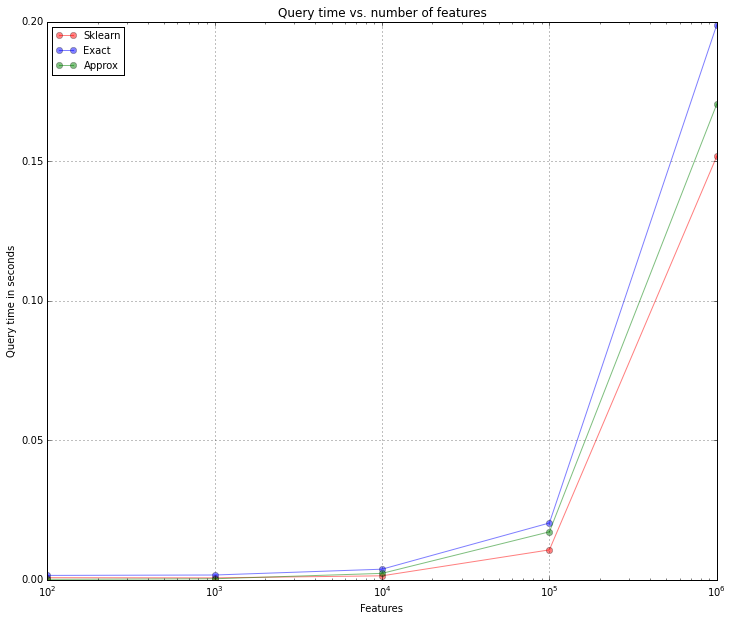

In [6]:
listOfFeatureSizes=[int(1e2), int(1e3), int(1e4), int(1e5), int(1e6)]
queryTime_featureSize(listOfFeatureSizes=listOfFeatureSizes)

#### Query time vs. number of instances

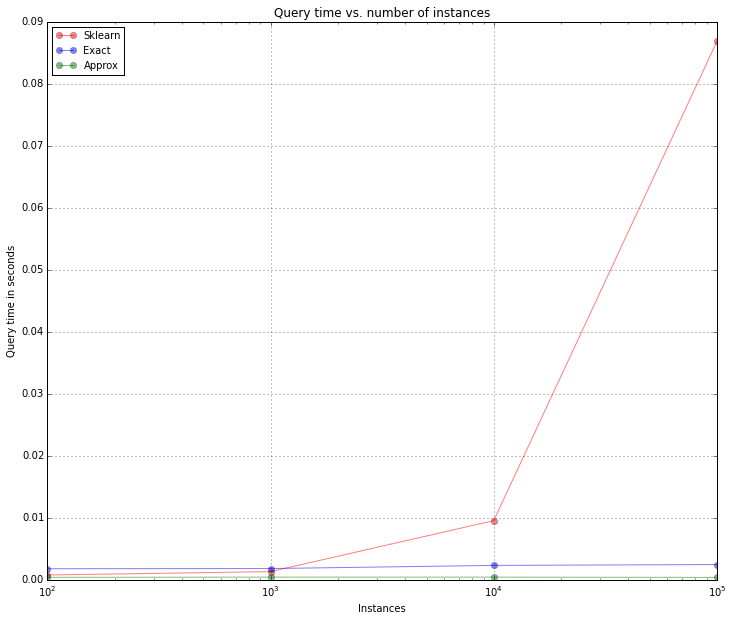

In [7]:
listOfInstances=[int(1e2), int(1e3), int(1e4), int(1e5)]
queryTime_numberOfInstances(listOfInstances=listOfInstances)

#### Query time vs. density of the sparse dataset

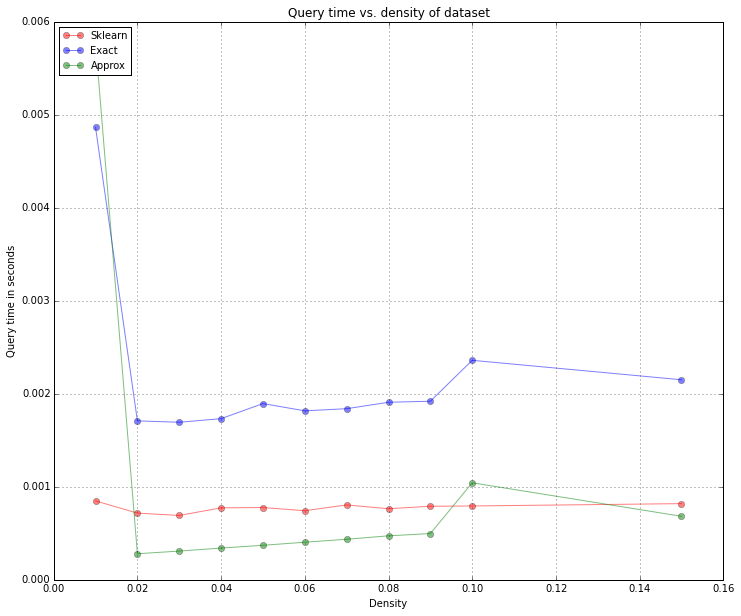

In [8]:
listOfDensity = [0.01, 0.02, 0.03, 0.04, 0.05,0.06,0.07,0.08,0.09,0.1,0.15]
queryTime_density(listOfDensity=listOfDensity)

#### Query time vs. number of hash functions

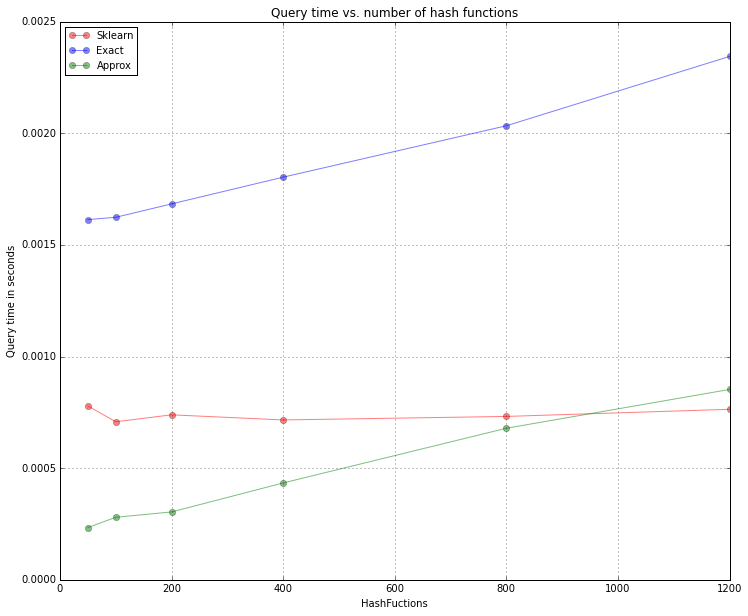

In [9]:
listOfHashFunctions = [50, 100, 200, 400, 800, 1200]
queryTime_numberOfHashFunctions(listOfHashFunctions=listOfHashFunctions)

#### Query time vs. the block size
Block size is used for the number of hash functions which are taken together as one.  
Eg. 400 Hash functions, block size of 4 --> 400 / 4 = 100 min hash functions 

In [ ]:
listOfBlockSize = [1,2,3,4, 5,6,7,8,9, 10, 15, 20]
queryTime_blockSize(listOfBlockSize=listOfBlockSize)

#### Accuracy vs. number of hash functions

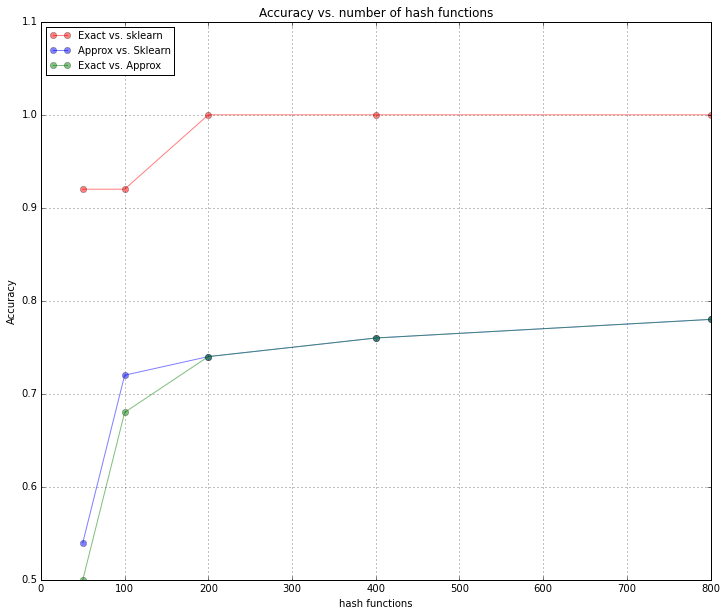

In [27]:
listOfHashFunctions = [50, 100, 200, 400, 800]
accuracy_numberOfHashFunctions(listOfHashFunctions=listOfHashFunctions)

#### Accuracy vs. maximal bin size
The maximal bin size defines how many collisions for one hashfunction and one hash value are allowed.

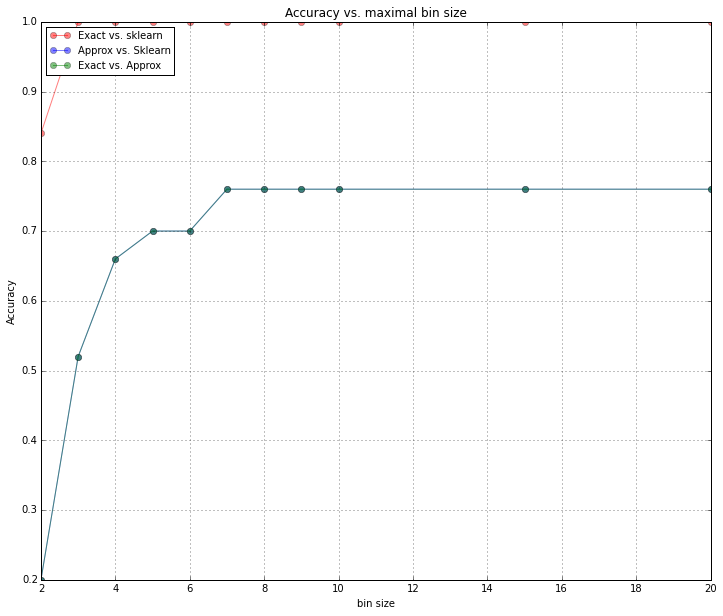

In [28]:
listOfMaxBinSize = [2,3,4, 5,6,7,8,9, 10, 15, 20]
accuracy_maxBinSize(listOfMaxBinSize=listOfMaxBinSize)

#### Accuracy vs. minimal blocks in common
Minimal blocks in common defines how many hash collisions two instances have to have to be considered.

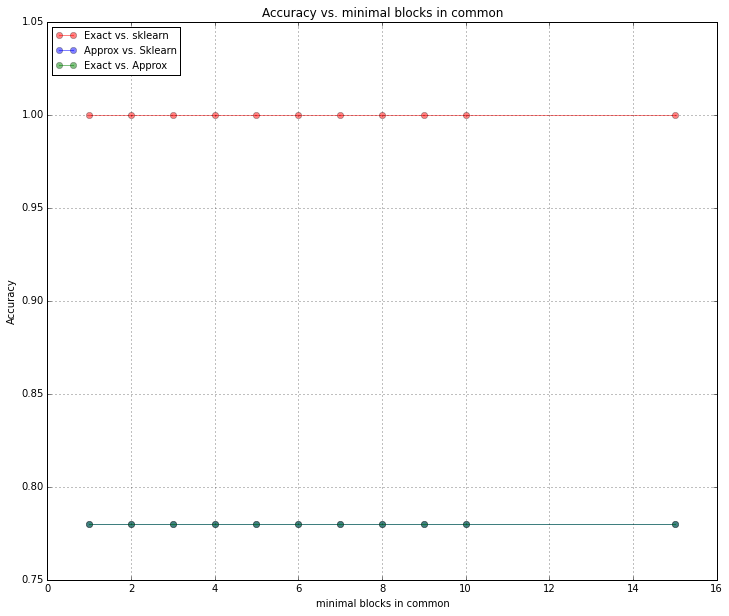

In [29]:
listOfminimalBlocksInCommon = [1,2,3,4,5,6,7,8,9,10,15]
accuracy_minimalBlocksInCommon(listOfminimalBlocksInCommon=listOfminimalBlocksInCommon)

####Accuracy vs. block size

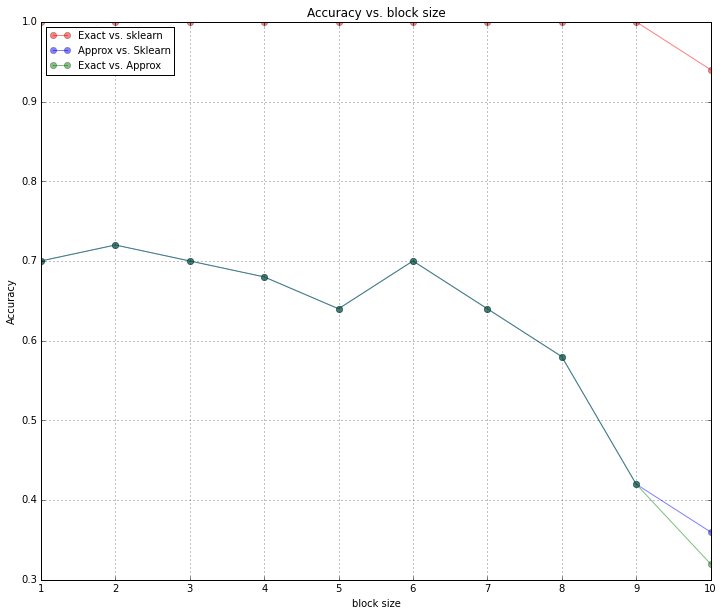

In [30]:
listOfBlockSize = [1,2,3,4,5,6,7,8,9,10]
accuracy_blockSize(listOfBlockSize=listOfBlockSize)

####Accuracy vs. density of the sparse dataset

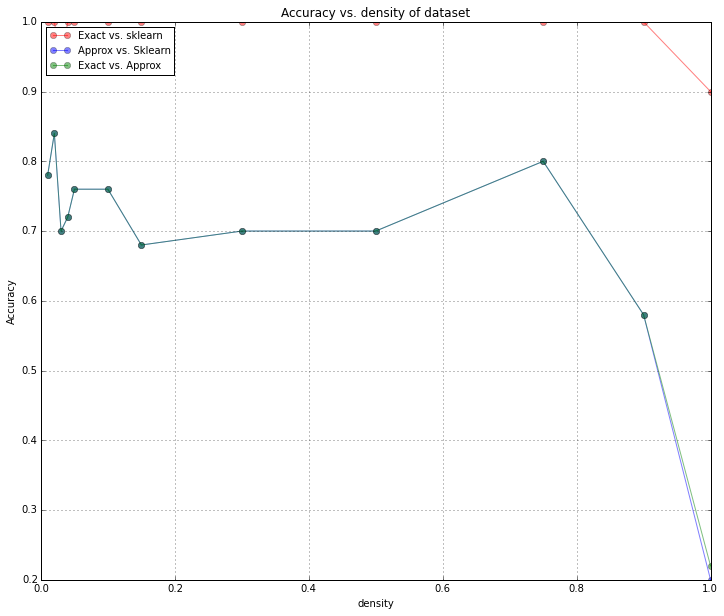

In [31]:
listOfDensity = [0.01, 0.02, 0.03, 0.04, 0.05,0.1,0.15, 0.3, 0.5, 0.75, 0.9, 1]
accuracy_density(listOfDensity=listOfDensity)